In [84]:
import cassio

import os
from dotenv import load_dotenv
load_dotenv()
    
os.getenv("ASTRA_DB_APPLICATION_TOKEN")

os.getenv("ASTRA_DB_ID_MULTI_AGENT")

Python-dotenv could not parse statement starting at line 13
Python-dotenv could not parse statement starting at line 14
Python-dotenv could not parse statement starting at line 15


'347103f4-38c3-48b1-99f5-e8fefdcd37f3'

In [85]:
#init db
ASTRA_DB_APPLICATION_TOKEN="AstraCS:niTCtvHqEvOWZroxeEkAovYs:d948b586008efecdd8f7d5d736bceb014a4172e59355a369b0d1ec723b48885c"
ASTRA_DB_ID_MULTI_AGENT = "347103f4-38c3-48b1-99f5-e8fefdcd37f3"

cassio.init(token = ASTRA_DB_APPLICATION_TOKEN, database_id=ASTRA_DB_ID_MULTI_AGENT)

In [86]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader

In [87]:
URLS = [
    "https://www.geeksforgeeks.org/agents-artificial-intelligence/",
    "https://mailchimp.com/resources/prompt-engineering/?ds_c=DEPT_AOC_Google_Search_ROW_EN_NB_Acquire_Broad_DSA-Rsrc-50off_T3&ds_kids=p80707256269&ds_a_lid=dsa-2227026702184&ds_cid=71700000119749229&ds_agid=58700008765758822&gad_source=1&gclid=Cj0KCQiAyoi8BhDvARIsAO_CDsBDPoj13v7--ZEdp8Fq2jZuuOv-Lfy0HwK2aoiaQlK2Nlp_ogJI3TUaAqSrEALw_wcB&gclsrc=aw.ds",
    "https://tuananhbui89.github.io/blog/2024/paper-llm-attacks/",
    "https://imdeepak.in"
]

In [88]:
docs = [WebBaseLoader(url).load() for url in URLS]
doc_list = [item for sublist in docs for item in sublist] 

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(chunk_size=500, chunk_overlap=0)
docs_split = text_splitter.split_documents(doc_list)
docs_split

[Document(metadata={'source': 'https://www.geeksforgeeks.org/agents-artificial-intelligence/', 'title': 'Agents in Artificial Intelligence - GeeksforGeeks', 'description': 'A Computer Science portal for geeks. It contains well written, well thought and well explained computer science and programming articles, quizzes and practice/competitive programming/company interview Questions.', 'language': 'en-US'}, page_content='Agents in Artificial Intelligence - GeeksforGeeks\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nSkip to content'),
 Document(metadata={'source': 'https://www.geeksforgeeks.org/agents-artificial-intelligence/', 'title': 'Agents in Artificial Intelligence - GeeksforGeeks', 'description': 'A Computer Science portal for geeks. It contains well written, well thought and well explained computer science and programming articles, quizzes and practice/competitive programming/company interview Questions.', 'language': 'en-US'}, page_content="Co

In [89]:
from langchain_huggingface import HuggingFaceEmbeddings
embeddings = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

In [90]:
from langchain.vectorstores.cassandra import Cassandra
astra_vector_store = Cassandra(
    embedding=embeddings,
    table_name="multi_agents_tbl",
    session=None,
    keyspace=None
)

In [91]:
from langchain.indexes.vectorstore import VectorStoreIndexWrapper
astra_vector_store.add_documents(documents=docs_split)
print("Inserted %i headlines." % len(docs_split))
astra_vector_index=VectorStoreIndexWrapper(vectorstore=astra_vector_store)

Inserted 60 headlines.


In [92]:
# Langgraph application
from typing import Literal
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field

In [93]:
retriever=astra_vector_store.as_retriever()
retriever.invoke("who is deepak kumar",ConsistencyLevel="LOCAL_ONE")

[Document(id='17daf16040e54de9a2ce6a3e0e0d1e7b', metadata={'description': 'Experienced React/JavaScript Developer with 7+ years  years of expertise. Deepak Kumar excels in developing high-quality web applications using modern frameworks like React, Node.js, and Next.js for seamless software development.', 'language': 'en', 'source': 'https://imdeepak.in', 'title': 'Deepak Kumar | Expert React & JavaScript Developer'}, page_content="Deepak Kumar | Expert React & JavaScript Developer✕Connect with Me!+91-8285257636dpk1391981@gmail.comDeepak KumarMy Professional Software Saga/ | Me | Experience | Education | Skills | Deepak KumarJavaScript | Full Stack | Node js | React js | Angular Js | MySql | NoSqlExperienced Software Engineer with  7+ years  of experience, combining technical expertise, strategic problem-solving, and leadership abilities. Skilled in guiding teams to deliver scalable solutions, optimizing processes, and adapting to new technologies. Passionate about creating innovative 

In [94]:
# Data Model
class RoueQuery(BaseModel):
    """Route a user query to the most relevent datasource"""
    datasource: Literal["vectorstore", "wiki_search","sql_agent"] = Field(
        ...,
        description="Given a user question choose to route it to wikipedia or a vectorstore or a sql agent."
    )

In [95]:
import os
from langchain_groq import ChatGroq
from dotenv import load_dotenv
load_dotenv()

os.environ["LANGCHAIN_API_KEY"] = os.getenv("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = os.getenv("LANGCHAIN_TRACING_V2")
os.environ["LANGCHAIN_PROJECT"] = "LogsLanggraph"

api_key = os.getenv("GROQ_API_KEY")

Python-dotenv could not parse statement starting at line 13
Python-dotenv could not parse statement starting at line 14
Python-dotenv could not parse statement starting at line 15


In [96]:
llm = ChatGroq(groq_api_key=api_key, model="gemma2-9b-it", streaming=True)

In [97]:
llm_route = llm.with_structured_output(RoueQuery)

In [98]:
#prompt
system="""
You are an expert at routing a user question to a vectorstore or wikipedia. The vectorstore contains documents related to agents , prompt engineering, and adversarial attact. Use the vectorstore for question on these topics. Otherwise use wikipedia.
"""
route_prompt = ChatPromptTemplate.from_messages([
    ("system", system),
    ("human", "{question}")
])

question_routes = route_prompt | llm_route

In [99]:
print(question_routes.invoke({"question": "what is agents?"}))

datasource='vectorstore'


In [117]:
print(question_routes.invoke({"question": "how many receipt we have for facility"}))

datasource='sql_agent'


In [101]:
# Create multiple tools

#1. Arxiv, 2. Wiki

from langchain_community.utilities import  WikipediaAPIWrapper
from langchain_community.tools import   WikipediaQueryRun

#wiki
wiki_wrapper = WikipediaAPIWrapper(top_k_results=1, doc_content_chars_max=300)
wiki_tool = WikipediaQueryRun(api_wrapper=wiki_wrapper)

In [102]:
from langchain.sql_database import SQLDatabase
from sqlalchemy import create_engine

In [103]:
def config_mysql_db(mysql_host, mysql_user, mysql_password, mysql_db):
    """Configure MySQL Database connection."""
    return SQLDatabase(create_engine(f"mysql+mysqlconnector://{mysql_user}:{mysql_password}@{mysql_host}/{mysql_db}"))
    

In [104]:
# Sidebar inputs for MySQL connection and Groq API Key
mysql_host = "localhost"
mysql_user = "genai"
mysql_password = "genai"
mysql_db = "offer_prm_uat"
api_key = "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"

query_limit = 100

db = config_mysql_db(mysql_host, mysql_user, mysql_password, mysql_db)

/var/www/learning/genAIApps/langchain-framework/langenv/lib/python3.10/site-packages/langchain_community/utilities/sql_database.py:123: SAWarning: Unknown schema content: '  KEY `\t\t'
  self._metadata.reflect(
/var/www/learning/genAIApps/langchain-framework/langenv/lib/python3.10/site-packages/langchain_community/utilities/sql_database.py:123: SAWarning: Unknown schema content: '\tblock_access_till_time` (`block_access_till_time`),'
  self._metadata.reflect(


In [105]:
few_shots = [
    {'Question' : "How many users we have?",
     'SQLQuery' : "SELECT count(*) FROM users'",
     'SQLResult': "Result of the SQL query",
     'Answer' : "1118"},
    {'Question': "How many facility or clinic we have ?",
     'SQLQuery':"SELECT count(*) FROM facility",
     'SQLResult': "Result of the SQL query",
     'Answer': "62"},
    {'Question': "how many users in Amanora clinics ?",
     'SQLQuery' : """SELECT COUNT(*) FROM users  INNER JOIN facility ON users.facility_id = facility.id WHERE facility.name = 'Amanora'""",
     'SQLResult': "Result of the SQL query",
     'Answer': "5"},
    {'Question': "how many receipt we have for last year?",
     'SQLQuery' : """SELECT COUNT(*) FROM reciept WHERE YEAR(rect_created_date) = YEAR(CURDATE()) - 1""",
     'SQLResult': "Result of the SQL query",
     'Answer': "480"},
#     {'Question': "If we have to sell all the Levi’s T-shirts today with discounts applied. How much revenue  our store will generate (post discounts)?" ,
#      'SQLQuery' : """SELECT sum(a.total_amount * ((100-COALESCE(discounts.pct_discount,0))/100)) as total_revenue from
# (select sum(price*stock_quantity) as total_amount, t_shirt_id from t_shirts where brand = 'Levi'
# group by t_shirt_id) a left join discounts on a.t_shirt_id = discounts.t_shirt_id
#  """,
#      'SQLResult': "Result of the SQL query",
#      'Answer': "16725.4"} ,
#      {'Question' : "If we have to sell all the Levi’s T-shirts today. How much revenue our store will generate without discount?" ,
#       'SQLQuery': "SELECT SUM(price * stock_quantity) FROM t_shirts WHERE brand = 'Levi'",
#       'SQLResult': "Result of the SQL query",
#       'Answer' : "17462"},
#     {'Question': "How many white color Levi's shirt I have?",
#      'SQLQuery' : "SELECT sum(stock_quantity) FROM t_shirts WHERE brand = 'Levi' AND color = 'White'",
#      'SQLResult': "Result of the SQL query",
#      'Answer' : "290"
#      },
#     {'Question': "how much sales amount will be generated if we sell all large size t shirts today in nike brand after discounts?",
#      'SQLQuery' : """SELECT sum(a.total_amount * ((100-COALESCE(discounts.pct_discount,0))/100)) as total_revenue from
# (select sum(price*stock_quantity) as total_amount, t_shirt_id from t_shirts where brand = 'Nike' and size="L"
# group by t_shirt_id) a left join discounts on a.t_shirt_id = discounts.t_shirt_id
#  """,
#      'SQLResult': "Result of the SQL query",
#      'Answer' : "290"
#     }
]

In [106]:
from langchain.vectorstores import FAISS
to_vectorize = [" ".join(example.values()) for example in few_shots]
faiss_vectorstore = FAISS.from_texts(to_vectorize, embeddings, metadatas=few_shots)

In [107]:
from langchain.prompts import SemanticSimilarityExampleSelector,PromptTemplate,FewShotPromptTemplate
from langchain.chains.sql_database.prompt import PROMPT_SUFFIX, _mysql_prompt

example_selector = SemanticSimilarityExampleSelector.from_examples(
    examples=few_shots,
    embeddings=embeddings,
    vectorstore_cls=FAISS,
    k=5
)


mysql_prompt = """You are a MySQL expert. Given an input question, first create a syntactically correct MySQL query to run, then look at the results of the query and return the answer to the input question.
    Unless the user specifies in the question a specific number of examples to obtain, query for at most {top_k} results using the LIMIT clause as per MySQL. You can order the results to return the most informative data in the database.
    Never query for all columns from a table. You must query only the columns that are needed to answer the question. Wrap each column name in backticks (`) to denote them as delimited identifiers.
    Pay attention to use only the column names you can see in the tables below. Be careful to not query for columns that do not exist. Also, pay attention to which column is in which table.
    Pay attention to use CURDATE() function to get the current date, if the question involves "today".
    
    Use the following format:
    
    Question: Question here
    SQLQuery: Query to run with no pre-amble
    SQLResult: Result of the SQLQuery
    Answer: Final answer here
    
    No pre-amble.
    """

example_prompt = PromptTemplate(
    input_variables=["Question", "SQLQuery", "SQLResult","Answer",],
    template="\nQuestion: {Question}\nSQLQuery: {SQLQuery}\nSQLResult: {SQLResult}\nAnswer: {Answer}",
)

few_shot_prompt = FewShotPromptTemplate(
        example_selector=example_selector,
        example_prompt=example_prompt,
        prefix=mysql_prompt,
        suffix=PROMPT_SUFFIX,
        input_variables=["input", "table_info", "top_k"], #These variables are used in the prefix and suffix
    )

In [108]:
from langchain.agents.agent_toolkits import SQLDatabaseToolkit
toolkit = SQLDatabaseToolkit(llm=llm, db=db)

In [109]:
from langchain import hub
prompt_template = hub.pull("langchain-ai/sql-agent-system-prompt")
system_message = prompt_template.format(dialect="SQLite", top_k=5)

In [110]:
from langchain.agents import initialize_agent
from langchain.agents.agent_types import AgentType

agent = initialize_agent(
    tools=toolkit.get_tools(),
    llm=llm,
    agent=AgentType.ZERO_SHOT_REACT_DESCRIPTION,
    verbose=True,
    handle_parsing_errors=True,  # Enable parsing error handling
    prompt=system_message,  # Use the FewShotPromptTemplate
)

In [111]:
#Start building chatbot using langgraph

from typing import Annotated, List
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

class GraphState(TypedDict):
    question: str
    generation:str
    documents: List[str]

In [112]:
from langchain.schema import Document


def retrieve(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    question = state["question"]

    # Retrieval
    documents = retriever.invoke(question)
    return {"documents": documents, "question": question}

In [113]:
def wiki_search(state):
    """
    wiki search based on the re-phrased question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with appended web results
    """

    print("---wikipedia---")
    print("---HELLO--")
    question = state["question"]
    print(question)

    # Wiki search
    docs = wiki_tool.invoke({"query": question})
    #print(docs["summary"])
    wiki_results = docs
    wiki_results = Document(page_content=wiki_results)

    return {"documents": wiki_results, "question": question}

In [114]:
def sql_agent(state):
    """
    sql search based on the re-phrased question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with appended web results
    """

    print("---sql agent---")
    print("---HELLO--")
    question = state["question"]
    print(question)
    limited_query = f"{question} LIMIT {query_limit}"
    # Wiki search
    docs = agent.run(limited_query)
    #print(docs["summary"])
    wiki_results = docs
    wiki_results = Document(page_content=wiki_results)

    return {"documents": wiki_results, "question": question}

In [115]:
### Edges ###


def route_question(state):
    """
    Route question to wiki search or RAG.

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """

    print("---ROUTE QUESTION---")
    question = state["question"]
    source = question_routes.invoke({"question": question})
    if source.datasource == "wiki_search":
        print("---ROUTE QUESTION TO Wiki SEARCH---")
        return "wiki_search"
    elif source.datasource == "vectorstore":
        print("---ROUTE QUESTION TO RAG---")
        return "vectorstore"
    elif source.datasource == "sql_agent":
        return "sql_agent"

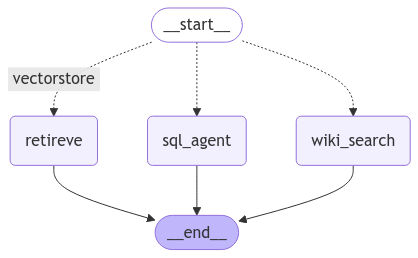

In [119]:
workflow=StateGraph(GraphState)

#define nodes
workflow.add_node("wiki_search", wiki_search)
workflow.add_node("retireve", retrieve)
workflow.add_node("sql_agent", sql_agent)

#build the graph
workflow.add_conditional_edges(
    START,
    route_question,
    {
        "sql_agent": "sql_agent",
        "wiki_search":"wiki_search",
        "vectorstore": "retireve"
    }
)
workflow.add_edge("sql_agent", END)
workflow.add_edge("retireve", END)
workflow.add_edge("wiki_search", END)
app = workflow.compile()
app

In [120]:
from pprint import pprint


#run multi agents
inputs = {
    "question": "how many receipt we have for last year ?"
}

for output in app.stream(inputs):
    # pprint(output)
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")

# Final generation
pprint(value['documents'][0].model_dump()["metadata"]["description"])

---ROUTE QUESTION---
---sql agent---
---HELLO--
how many receipt we have for last year ?


> Entering new AgentExecutor chain...


/tmp/ipykernel_2333/1710960870.py:18: LangChainDeprecationWarning: The method `Chain.run` was deprecated in langchain 0.1.0 and will be removed in 1.0. Use :meth:`~invoke` instead.
  docs = agent.run(limited_query)


Thought: I need to know the structure of the receipts table and what columns are relevant to the date.
Action: sql_db_list_tables
Action Input: 
Observation: PAYRECO_PRMCASH_PTCASH_CORRCETION, accessories, accessory_incidence, accessory_transfer, acos, addresses, advancereceiptwithfraction, ageing_reports, ageing_treatmentwise_reports, allocation_histories, amc_misc_data, appointment_expired_reasons, aros, aros_acos, aros_delete_ids, asset_accessory_map, asset_category, asset_incidence, asset_incidence_images, asset_transfer, asset_transfer_accessories, asset_transfer_images, assets_master, authorities, automatic_notification, billing, billing_consumed_aligner_stages_mapping, blocked_contact, blocked_emails_temp, call_info_disposition_relations, call_infos, call_qualites, camp_field_dentist_zone_maps, camp_field_dentists, campaigns, camps, categories, categories_seq, cc_groups, cc_intensities, cc_lists, cc_locations, chart_tracker, check_sum_logs, checkup_config, checkup_data, checkup_

TypeError: 'Document' object is not subscriptable